<a href="https://colab.research.google.com/github/componavt/LLLE-R1900s/blob/main/src/visualization/grouped_bar_chart_bw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Grouped Bar Chart: Annual Loan Volumes & Counts by Credit Type

Visualizes **annual dynamics** of selected credit categories across all settlements.

**Top bars (↑)** = total loan amount (in **thousands of rubles**)  
**Bottom bars (↓)** = total number of loans  

Each selected credit type is shown with:
- **Unique color**
- **Consistent style** for both amount and count (same color for ↑ and ↓)

✨ **Features:**
- 🌍 Fully bilingual: toggle between Russian (`ru`) and English (`en`)
- 📅 X-axis = years (e.g., 1913–1917)
- 🎨 Configurable credit types via `SELECTED_CREDIT_ITEMS`
- 📈 Dual-axis: positive (amount) and negative (count) bars share color per category
- 🖼️ Rendered directly in Google Colab

⚙️ Configure via:
- `USE_LANGUAGE` — `"ru"` or `"en"`
- `SELECTED_CREDIT_ITEMS` — list of `Name` values from `credit_items.csv`

⚙️ [2] Install Dependencies & Set Language + Credit Selection

In [37]:
# Install dependencies for data processing and static plotting
!apt-get update -qq
!apt-get install -yqq libxcb-cursor0 libxcb-shm0 libxcb-xfixes0 libxcb-render0 libxcb-randr0 libxcb-glx0 libxkbcommon0

# We do NOT install kaleido or plotly>=6.1.1 since we'll use matplotlib for static output
!pip install -q python-dotenv pandas plotly matplotlib

# Clone the repo if running in Colab (optional — if data not uploaded manually)
import os

if not os.path.exists('LLLE-R1900s'):
    !git clone https://github.com/componavt/LLLE-R1900s.git
    %cd LLLE-R1900s
else:
    %cd LLLE-R1900s

# === LANGUAGE SWITCH ===
USE_LANGUAGE = "ru"
assert USE_LANGUAGE in ("ru", "en"), "USE_LANGUAGE must be 'ru' or 'en'"

# === SELECT CREDIT TYPES TO VISUALIZE ===
SELECTED_CREDIT_ITEMS = ["Migration", "CraftMaterials", "CraftTools"]

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Cloning into 'LLLE-R1900s'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 693 (delta 69), reused 13 (delta 5), pack-reused 583 (from 1)
Receiving objects: 100% (693/693), 8.04 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (506/506), done.
/content/LLLE-R1900s/LLLE-R1900s/LLLE-R1900s/LLLE-R1900s/LLLE-R1900s


📥 [3] Load & Prepare Data

In [38]:
import os
import pandas as pd
from dotenv import load_dotenv

# Validate SELECTED_CREDIT_ITEMS early (now that pandas is available)
valid_names = set(pd.read_csv('data/credit_items.csv')['Name'])
invalid = set(SELECTED_CREDIT_ITEMS) - valid_names
if invalid:
    raise ValueError(f"Invalid credit item(s): {invalid}. Must be from 'Name' column in credit_items.csv.")

# Load configuration
load_dotenv('config.env')

# Paths
csv_out_dir = os.getenv('CSV_OUT_DIR', 'data/csv_out')
output_file_name = os.getenv('OUTPUT_CSV_FILE')

if not output_file_name:
    csv_files = [f for f in os.listdir(csv_out_dir) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the output directory.")
    output_file_name = csv_files[0]

csv_path = os.path.join(csv_out_dir, output_file_name)
print(f"Loading loan data from: {csv_path}")

# Load main loan data
df_loans = pd.read_csv(csv_path)
print(f"Loaded {len(df_loans)} loan records.")

# Load credit items
df_credit = pd.read_csv('data/credit_items.csv')
print(f"Loaded {len(df_credit)} credit item definitions.")

# --- Build credit item display label map ---
if USE_LANGUAGE == "ru":
    df_credit['display_label'] = df_credit['loan_short_ru']
else:
    df_credit['display_label'] = df_credit['Name']

label_map = dict(zip(df_credit['Name'], df_credit['display_label']))

# Filter loans to only selected credit items
df_loans = df_loans[df_loans['credit_item'].isin(SELECTED_CREDIT_ITEMS)].copy()

# Ensure numeric types
df_loans['amount_rubles'] = pd.to_numeric(df_loans['amount_rubles'], errors='coerce').fillna(0)
df_loans['loan_count'] = pd.to_numeric(df_loans['loan_count'], errors='coerce').fillna(0).astype(int)

print(f"Filtered to {len(df_loans)} records for selected credit types: {SELECTED_CREDIT_ITEMS}")

Loading loan data from: data/csv_out/loans_s28_i21.csv
Loaded 1768 loan records.
Loaded 21 credit item definitions.
Filtered to 264 records for selected credit types: ['Migration', 'CraftMaterials', 'CraftTools']


🔍 [4] Calculate Axis Extents and Prepare Annotations

In [39]:
# Aggregate by year and credit_item
df_annual = df_loans.groupby(['year', 'credit_item']).agg(
    total_amount=('amount_rubles', 'sum'),
    total_count=('loan_count', 'sum')
).reset_index()

df_annual['total_amount_k'] = df_annual['total_amount'] / 1000.0

years = sorted(df_annual['year'].unique())
credit_items = SELECTED_CREDIT_ITEMS

max_amount = df_annual['total_amount_k'].max() if not df_annual.empty else 1
max_count = df_annual['total_count'].max() if not df_annual.empty else 1

print(f"📈 Max loan amount (thsd rub): {max_amount:.2f}")
print(f"📊 Max loan count: {max_count}")

# --- Normalize both series to [-1, 1] range for visual balance ---
# We'll map [0, max_amount] → [0, 1] and [0, max_count] → [0, -1]
amount_norm = {}
count_norm = {}
amount_annotations = {}
count_annotations = {}

CREDIT_SYMBOLS = {
    "Migration": "🚶",
    "CraftMaterials": "🧵",
    "CraftTools": "🔨"
}

for item in credit_items:
    subset = df_annual[df_annual['credit_item'] == item]
    amount_dict = dict(zip(subset['year'], subset['total_amount_k']))
    count_dict = dict(zip(subset['year'], subset['total_count']))

    raw_amounts = [amount_dict.get(y, 0) for y in years]
    raw_counts = [count_dict.get(y, 0) for y in years]

    # Normalize
    norm_amounts = [a / max_amount if max_amount > 0 else 0 for a in raw_amounts]
    norm_counts = [-c / max_count if max_count > 0 else 0 for c in raw_counts]  # negative direction

    amount_norm[item] = norm_amounts
    count_norm[item] = norm_counts

    # Annotations show REAL values (not normalized)
    amount_annotations[item] = [f"{a:.1f}" if a > 0 else "" for a in raw_amounts]
    count_annotations[item] = [
        f"{CREDIT_SYMBOLS.get(item, '')}\n{int(c)}" if c > 0 else ""
        for c in raw_counts
    ]

# Store for cell 5
PLOT_DATA = {
    'years': years,
    'credit_items': credit_items,
    'amount_norm': amount_norm,
    'count_norm': count_norm,
    'amount_annotations': amount_annotations,
    'count_annotations': count_annotations,
    'max_amount': max_amount,
    'max_count': max_count
}

📈 Max loan amount (thsd rub): 9.56
📊 Max loan count: 249


📊 [5] Grouped Bar Chart: Annual Amount (↑) and Count (↓) by Credit Type
(Balanced Visual Scales and Custom Y-axis Labels)

In [40]:
import plotly
import plotly.graph_objects as go
import os

years = PLOT_DATA['years']
credit_items = PLOT_DATA['credit_items']
amount_norm = PLOT_DATA['amount_norm']
count_norm = PLOT_DATA['count_norm']
amount_annotations = PLOT_DATA['amount_annotations']
count_annotations = PLOT_DATA['count_annotations']
max_amount = PLOT_DATA['max_amount']
max_count = PLOT_DATA['max_count']

# Unicode symbols for legend
CREDIT_SYMBOLS = {
    "Migration": "🚶",
    "CraftMaterials": "🧵",
    "CraftTools": "🔨"
}

fig = go.Figure()

colors = plotly.colors.qualitative.Plotly

# Add traces (using normalized Y values)
for i, item in enumerate(credit_items):
    color = colors[i % len(colors)]
    base_label = label_map[item]
    symbol = CREDIT_SYMBOLS.get(item, "")
    legend_label = f"{base_label} {symbol}".strip()

    # Amount (normalized upward)
    fig.add_trace(go.Bar(
        x=years,
        y=amount_norm[item],
        name=legend_label,
        marker_color=color,
        offsetgroup=i,
        legendgroup=item,
        text=amount_annotations[item],
        textposition='outside',
        textfont=dict(size=10),
        hovertemplate=(
            (f"<b>{base_label}</b><br>Year: %{{x}}<br>Amount: %{{text}}k rub" if USE_LANGUAGE == "en"
             else f"<b>{base_label}</b><br>Год: %{{x}}<br>Сумма: %{{text}} тыс. руб.")
            + "<extra></extra>"
        )
    ))

    # Count (normalized downward)
    fig.add_trace(go.Bar(
        x=years,
        y=count_norm[item],
        name=legend_label,
        marker_color=color,
        opacity=0.75,
        offsetgroup=i,
        legendgroup=item,
        showlegend=False,
        text=count_annotations[item],
        textposition='outside',
        textfont=dict(size=10),
        hovertemplate=(
            (f"<b>{base_label}</b><br>Year: %{{x}}<br>Loans: %{{text.split()[-1]}}" if USE_LANGUAGE == "en"
             else f"<b>{base_label}</b><br>Год: %{{x}}<br>Ссуд: %{{text.split()[-1]}}")
            + "<extra></extra>"
        )
    ))

# --- Custom Y-axis tick labels ---
n_ticks_top = 5
tickvals_top = [i / (n_ticks_top - 1) for i in range(n_ticks_top)]
ticktext_top = [f"{(i / (n_ticks_top - 1)) * max_amount:.1f}" for i in range(n_ticks_top)]

n_ticks_bottom = 5
tickvals_bottom = [-i / (n_ticks_bottom - 1) for i in range(n_ticks_bottom)]
ticktext_bottom = [f"{int((i / (n_ticks_bottom - 1)) * max_count)}" for i in range(n_ticks_bottom)]

tickvals = tickvals_bottom[::-1][:-1] + tickvals_top
ticktext = ticktext_bottom[::-1][:-1] + ticktext_top

# Update layout
if USE_LANGUAGE == "en":
    yaxis_title = "Number of Loans ↓ / Amount (thsd rub) ↑"
    title = "Annual Loan Volume by Credit Type"
    legend_title_text = "Credit Type"
else:
    yaxis_title = "Число ссуд ↓ / Сумма (тыс. руб.) ↑"
    title = "Годовой объём ссуд по категориям"
    legend_title_text = "Тип ссуды"

fig.update_layout(
    title=title,
    barmode='group',
    xaxis=dict(
        title="Year" if USE_LANGUAGE == "en" else "Год",
        tickmode='linear'
    ),
    yaxis=dict(
        title=yaxis_title,
        tickmode='array',
        tickvals=tickvals,
        ticktext=ticktext,
        range=[-1.1, 1.1],
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='black'
    ),
    legend=dict(
        title=legend_title_text,
        traceorder="normal",
        x=0.01,          # X-позиция: 0 = левый край, 0.01 = небольшой отступ
        y=0.99,          # Y-позиция: 1 = верхний край, 0.99 = небольшой отступ сверху
        xanchor='left',  # Якорь по X — слева
        yanchor='top',   # Якорь по Y — сверху
        bgcolor='rgba(255, 255, 255, 0.8)',  # Полупрозрачный белый фон для читаемости
        bordercolor='black',
        borderwidth=0.5
    ),
    height=650,
    font=dict(size=12)
)

# Show in Colab
fig.show(renderer="colab")

print(f"\n✅ Displayed balanced grouped bar chart for {len(credit_items)} credit types.")


✅ Displayed balanced grouped bar chart for 3 credit types.


📊 [6] Static Grouped Bar Chart using Matplotlib (no emoji, Balanced Scales via Normalization, Custom Hatch, and Positive Y Labels)


=== СТАТИСТИКА ПО ТОВАРИЩЕСТВАМ ДЛЯ ЭТОГО ГРАФИКА ===
Загружено исходных данных: 1768 записей
Отфильтровано записей по выбранным типам: 264

Всего товариществ с выбранными типами ссуд: 22

Товарищество    | Отхожий промысел          | Ремесленные материалы     | Ремесленные инструменты  
--------------------------------------------------------------------------------------------------------------
Nigizhemskoye   |  37 ссуд /      625 руб. | 111 ссуд /     3220 руб. |  76 ссуд /     1995 руб.
Velikaya Guba   | 116 ссуд /     5980 руб. |  65 ссуд /     2340 руб. |  29 ссуд /      765 руб.
Gimoretskoye    | 101 ссуд /     1636 руб. |  44 ссуд /     2459 руб. |  32 ссуд /      815 руб.
Kotkozero       |  30 ссуд /      585 руб. |  27 ссуд /      907 руб. |  26 ссуд /      694 руб.
Kuzaranda       |  39 ссуд /      900 руб. |  30 ссуд /     1482 руб. |   6 ссуд /      220 руб.
Megregskoye     |   9 ссуд /      510 руб. |  49 ссуд /     2435 руб. |   3 ссуд /       80 руб.
Sennaya Guba    |

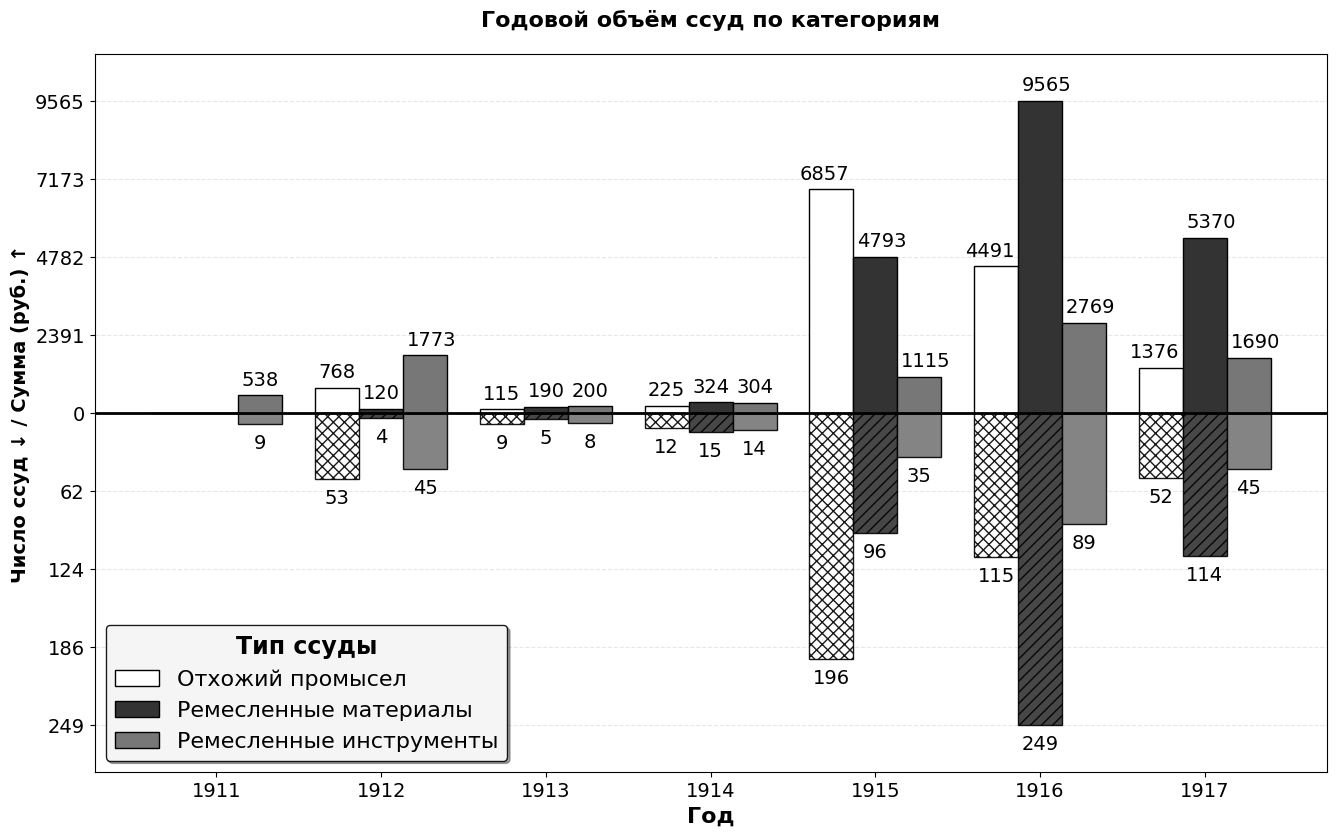

In [41]:
# 📊 [6] Static Grouped Bar Chart using Matplotlib (no emoji, Balanced Scales via Normalization, Custom Hatch, and Positive Y Labels)

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd  # Added for Alexander's statistics code

# === CODE FOR ALEXANDER'S QUESTION ===
print("\n=== СТАТИСТИКА ПО ТОВАРИЩЕСТВАМ ДЛЯ ЭТОГО ГРАФИКА ===")

# Load original data with settlement information
original_csv_path = os.path.join(csv_out_dir, output_file_name)
df_original = pd.read_csv(original_csv_path)
print(f"Загружено исходных данных: {len(df_original)} записей")

# Filter by selected credit types
selected_df = df_original[df_original['credit_item'].isin(SELECTED_CREDIT_ITEMS)].copy()
print(f"Отфильтровано записей по выбранным типам: {len(selected_df)}")

# Convert to numeric values
selected_df['amount_rubles'] = pd.to_numeric(selected_df['amount_rubles'], errors='coerce').fillna(0)
selected_df['loan_count'] = pd.to_numeric(selected_df['loan_count'], errors='coerce').fillna(0).astype(int)

# Group by settlements and credit types
society_stats = {}
for settlement in selected_df['settlement'].unique():
    settlement_data = selected_df[selected_df['settlement'] == settlement]
    stats = {}
    for item in SELECTED_CREDIT_ITEMS:
        item_data = settlement_data[settlement_data['credit_item'] == item]
        total_count = item_data['loan_count'].sum()
        total_amount = item_data['amount_rubles'].sum()
        stats[item] = (int(total_count), float(total_amount))
    society_stats[settlement] = stats

# Print statistics
print(f"\nВсего товариществ с выбранными типами ссуд: {len(society_stats)}\n")
print(f"{'Товарищество':15} | {'Отхожий промысел':25} | {'Ремесленные материалы':25} | {'Ремесленные инструменты':25}")
print("-" * 110)

# Sort by total number of loans
sorted_societies = sorted(
    society_stats.keys(),
    key=lambda s: sum(stats[0] for stats in society_stats[s].values()),
    reverse=True
)

for settlement in sorted_societies:
    stats = society_stats[settlement]

    # Get data for each credit type
    migration = stats.get("Migration", (0, 0))
    materials = stats.get("CraftMaterials", (0, 0))
    tools = stats.get("CraftTools", (0, 0))

    print(f"{settlement:15} | {migration[0]:3d} ссуд / {migration[1]:8.0f} руб. | "
          f"{materials[0]:3d} ссуд / {materials[1]:8.0f} руб. | "
          f"{tools[0]:3d} ссуд / {tools[1]:8.0f} руб.")

print("\n💡 На графике показаны ВСЕ товарищества, в которых хотя бы раз встречались выбранные типы ссуд. "
      "Всего таких товариществ: " + str(len(society_stats)) + ". "
      "Данные отфильтрованы только по типам ссуд (Отхожий промысел, Ремесленные материалы, Ремесленные инструменты), "
      "но включают все товарищества, где эти ссуды выдавались.")

# Use normalized data prepared in cell [4] for visual balance
years = PLOT_DATA['years']
credit_items = PLOT_DATA['credit_items']
amount_norm = PLOT_DATA['amount_norm']  # Already normalized to [0, 1]
count_norm = PLOT_DATA['count_norm']    # Already normalized to [0, -1]
# We need REAL ruble amounts (not /1000) for annotations and axis labels
max_amount_rub = PLOT_DATA['max_amount'] * 1000  # Convert back to rubles
max_count = PLOT_DATA['max_count']

# Reconstruct REAL ruble data for annotations (not divided by 1000)
df_annual = df_loans.groupby(['year', 'credit_item']).agg(
    total_amount_rub=('amount_rubles', 'sum'),  # Keep in rubles
    total_count=('loan_count', 'sum')
).reset_index()

# Prepare real ruble data arrays for annotations
amount_annotations_rub = {}
count_annotations = {}  # Reuse logic but ensure count is int
CREDIT_SYMBOLS = {
    "Migration": "🚶",
    "CraftMaterials": "🧵",
    "CraftTools": "🔨"
}
for item in credit_items:
    subset = df_annual[df_annual['credit_item'] == item]
    amount_dict = dict(zip(subset['year'], subset['total_amount_rub']))
    count_dict = dict(zip(subset['year'], subset['total_count']))
    # Annotations: rubles as integers, counts with symbol
    amount_annotations_rub[item] = [
        f"{int(amount_dict.get(y, 0))}" if amount_dict.get(y, 0) > 0 else ""
        for y in years
    ]
    count_annotations[item] = [
        f"{CREDIT_SYMBOLS.get(item, '')}\n{int(c)}" if c > 0 else ""
        for c in [count_dict.get(y, 0) for y in years]
    ]

# Set up the plot
fig, ax1 = plt.subplots(figsize=(14, 9))  # Increase figure size for better readability

n_years = len(years)
n_items = len(credit_items)
total_width = 0.8
bar_width = total_width / n_items
x = np.arange(n_years)

# === MANUAL COLOR ASSIGNMENT FOR B/W PRINTING ===
colors = []
for i, item in enumerate(credit_items):
    if item == "Migration":  # Temporary earnings → white for B/W
        colors.append("white")
    elif item == "CraftMaterials":  # Craft materials → dark gray
        colors.append("#333333")
    elif item == "CraftTools":  # Craft tools → medium gray
        colors.append("#777777")
    else:
        colors.append(plt.cm.tab10(i % 10))

# Replace label for Russian language
if USE_LANGUAGE == "ru" and "Migration" in label_map:
    label_map["Migration"] = "Отхожий промысел"

# Define hatch patterns per credit item
HATCH_MAP = {
    "CraftTools": "",        # solid
    "CraftMaterials": "///", # diagonal lines
    "Migration": "xxx"       # crosses
}

# Plot upward bars (normalized amount: [0, 1])
for i, item in enumerate(credit_items):
    offset = (i - n_items / 2) * bar_width + bar_width / 2
    bars = ax1.bar(
        x + offset,
        amount_norm[item],
        width=bar_width,
        label=label_map[item],
        color=colors[i],
        edgecolor='black',
        linewidth=1.0,  # Increase contour thickness for better visibility
        zorder=3  # Place bars above grid
    )
    # Add amount labels (real rubles as integers)
    for j, (bar, val_str) in enumerate(zip(bars, amount_annotations_rub[item])):
      if val_str:
        # Convert string back to integer to check value
        val_num = int(val_str)

        # Calculate base x position
        text_x = bar.get_x() + bar.get_width() / 2

        # Special right shift for CraftTools (Ремесленные инструменты) to avoid overlap and high rectangles
        if item in ("CraftTools", "CraftMaterials") and val_num > 1000:
            # Shift right by approximately 3 pixels (relative to data coordinates)
            # This is a small shift - about 5% of bar width
            text_x += bar.get_width() * 0.15

        if item == "Migration" and val_num > 1000:
            text_x -= bar.get_width() * 0.15

        ax1.text(
            text_x,
            bar.get_height() + 0.02,
            val_str,
            ha='center', va='bottom', fontsize=14, #fontweight='bold',
            zorder=4
        )

# Plot downward bars (normalized count: [0, -1])
for i, item in enumerate(credit_items):
    offset = (i - n_items / 2) * bar_width + bar_width / 2
    hatch = HATCH_MAP.get(item, "")
    bars = ax1.bar(
        x + offset,
        count_norm[item],
        width=bar_width,
        color=colors[i],
        edgecolor='black',
        linewidth=1.0,  # Increase contour thickness
        alpha=0.9,  # Reduce transparency for better visibility
        hatch=hatch,
        zorder=2
    )
    # Add count labels (real values from annotations)
    for j, (bar, cnt_str) in enumerate(zip(bars, count_annotations[item])):
        if cnt_str:
            num_part = cnt_str.split('\n')[-1] if '\n' in cnt_str else cnt_str
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - 0.03,  # More offset for readability
                num_part,
                ha='center', va='top', fontsize=14, #fontweight='bold',  # Increased font size
                zorder=4
            )

# === SET BALANCED Y-AXIS LIMITS ===
ax1.set_ylim(-1.15, 1.15)

# Add grid for better readability
ax1.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)

# === CUSTOM Y-AXIS TICKS: Map normalized positions to REAL rubles and counts ===
# Top ticks: normalized [0,1] -> real rubles [0, max_amount_rub]
n_ticks_top = 5
norm_top_vals = np.linspace(0, 1, n_ticks_top)
real_top_vals = norm_top_vals * max_amount_rub
top_labels = [f"{int(v)}" for v in real_top_vals]  # Integer rubles

# Bottom ticks: normalized [-1,0] -> real counts [max_count, 0]
n_ticks_bottom = 5
norm_bottom_vals = np.linspace(-1, 0, n_ticks_bottom)
real_bottom_vals = -norm_bottom_vals * max_count
bottom_labels = [f"{int(v)}" for v in real_bottom_vals]

# Combine ticks
tick_positions = list(norm_bottom_vals[:-1]) + list(norm_top_vals)
tick_labels = bottom_labels[:-1] + top_labels

ax1.set_yticks(tick_positions)
ax1.set_yticklabels(tick_labels)

# Increase font size for axis tick labels
ax1.tick_params(axis='both', labelsize=14)

# Labels and titles (with updated Y-axis label: "rub" instead of "thsd rub")
if USE_LANGUAGE == "en":
    ax1.set_ylabel('Number of Loans ↓ / Amount (rub) ↑', fontsize=14, fontweight='bold')  # Increased font size
    ax1.set_xlabel('Year', fontsize=16, fontweight='bold')  # Increased font size
    title = "Annual Loan Volume by Credit Type"
    legend_title = "Credit Type"
else:
    ax1.set_ylabel('Число ссуд ↓ / Сумма (руб.) ↑', fontsize=14, fontweight='bold')  # Increased font size
    ax1.set_xlabel('Год', fontsize=16, fontweight='bold')  # Increased font size
    title = "Годовой объём ссуд по категориям"
    legend_title = "Тип ссуды"

ax1.set_title(title, fontsize=16, fontweight='bold', pad=20)  # Increased title font size
ax1.set_xticks(x)
ax1.set_xticklabels(years, fontsize=14)  # Increased font size for years

# Zero line
ax1.axhline(0, color='black', linewidth=2.0, zorder=5)  # Increase zero line thickness

# Legend with larger font
legend = ax1.legend(
    title=legend_title,
    fontsize=16,  # Increased legend font size
    title_fontsize=17,  # Increased legend title font size
    loc='lower left',
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.9,
    edgecolor='black'
)
legend.get_title().set_fontweight('bold')

plt.tight_layout(pad=3.0)  # Increase padding

# Save
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
items_str = "_".join(SELECTED_CREDIT_ITEMS)
lang_suffix = "en" if USE_LANGUAGE == "en" else "ru"
filename = f"grouped_bar_chart_{items_str}_{lang_suffix}.png"
filepath = os.path.join(output_dir, filename)

plt.savefig(filepath, dpi=300, bbox_inches='tight')
print(f"\n✅ Chart saved as: {filepath}")

# Save PDF version for journal publication
pdf_filename = f"grouped_bar_chart_{items_str}_{lang_suffix}.pdf"
pdf_filepath = os.path.join(output_dir, pdf_filename)
plt.savefig(pdf_filepath, bbox_inches='tight')
print(f"✅ PDF version (for journal) saved as: {pdf_filepath}")

plt.show()

 📊 [7] Detailed Statistical Analysis: Share of Non-Agricultural Loans in Total Credit Portfolio

In [44]:
# 📊 [7] Annual Analysis of Non-Agricultural Loans Share by Year (1911-1917)

import pandas as pd
import numpy as np
import os
import json

print("=== АНАЛИЗ ДОЛИ НЕЗЕМЛЕДЕЛЬЧЕСКИХ ССУД ПО ГОДАМ (1911-1917) ===\n")

# Load full data without filtering by loan types
full_csv_path = os.path.join(csv_out_dir, output_file_name)
df_full = pd.read_csv(full_csv_path)
print(f"Загружено полных данных: {len(df_full)} записей")

# Check and convert numeric fields
df_full['amount_rubles'] = pd.to_numeric(df_full['amount_rubles'], errors='coerce').fillna(0)
df_full['loan_count'] = pd.to_numeric(df_full['loan_count'], errors='coerce').fillna(0).astype(int)

# Define three target loan types
target_items = ["CraftTools", "CraftMaterials", "Migration"]
target_items_ru = {
    "CraftTools": "Ремесленные инструменты",
    "CraftMaterials": "Ремесленные материалы",
    "Migration": "Отхожий промысел"
}

# Create marker column for target types
df_full['is_target'] = df_full['credit_item'].isin(target_items)

# Calculate total counts and amounts by year (all loan types)
df_yearly_totals = df_full.groupby('year').agg(
    total_count_all=('loan_count', 'sum'),
    total_amount_all=('amount_rubles', 'sum')
).reset_index()

# Calculate totals for target loan types by year
df_target_yearly = df_full[df_full['is_target']].groupby('year').agg(
    target_count=('loan_count', 'sum'),
    target_amount=('amount_rubles', 'sum')
).reset_index()

# Merge target and total data
df_yearly_analysis = pd.merge(df_yearly_totals, df_target_yearly, on='year', how='left')

# Fill NaN values (if no target loans in some years)
df_yearly_analysis['target_count'] = df_yearly_analysis['target_count'].fillna(0)
df_yearly_analysis['target_amount'] = df_yearly_analysis['target_amount'].fillna(0)

# Calculate percentages
df_yearly_analysis['count_percent'] = (df_yearly_analysis['target_count'] / df_yearly_analysis['total_count_all']) * 100
df_yearly_analysis['amount_percent'] = (df_yearly_analysis['target_amount'] / df_yearly_analysis['total_amount_all']) * 100

# Create formatted table for display
print("\n📊 ГОДОВАЯ СТАТИСТИКА ПО ТРЁМ ЦЕЛЕВЫМ ТИПАМ ССУД (1911-1917 гг.):")
print("-" * 100)
print(f"{'Год':4} | {'Число всех ссуд':15} | {'Число целевых ссуд':20} | {'Доля (%)':10} | {'Общ. объём (руб.)':20} | {'Объём целевых (руб.)':20} | {'Доля (%)':10}")
print("-" * 100)

for _, row in df_yearly_analysis.iterrows():
    year = int(row['year'])
    total_count = int(row['total_count_all'])
    target_count = int(row['target_count'])
    count_percent = row['count_percent']
    total_amount = float(row['total_amount_all'])
    target_amount = float(row['target_amount'])
    amount_percent = row['amount_percent']

    print(f"{year:4d} | {total_count:15,d} | {target_count:20,d} | {count_percent:9.1f}% | {total_amount:20,.0f} | {target_amount:20,.0f} | {amount_percent:9.1f}%")

print("-" * 100)

# Calculate averages for pre-war period (1911-1914)
pre_war_years = [1911, 1912, 1913, 1914]
pre_war_data = df_yearly_analysis[df_yearly_analysis['year'].isin(pre_war_years)]

pre_war_avg = {
    'avg_target_count': pre_war_data['target_count'].mean(),
    'avg_count_percent': pre_war_data['count_percent'].mean(),
    'avg_target_amount': pre_war_data['target_amount'].mean(),
    'avg_amount_percent': pre_war_data['amount_percent'].mean()
}

# Calculate averages for war period (1915-1917)
war_years = [1915, 1916, 1917]
war_data = df_yearly_analysis[df_yearly_analysis['year'].isin(war_years)]

war_avg = {
    'avg_target_count': war_data['target_count'].mean(),
    'avg_count_percent': war_data['count_percent'].mean(),
    'avg_target_amount': war_data['target_amount'].mean(),
    'avg_amount_percent': war_data['amount_percent'].mean()
}

# Print period averages
print("\n📈 СРЕДНИЕ ЗНАЧЕНИЯ ПО ПЕРИОДАМ:")
print("-" * 80)
print(f"{'Показатель':40} | {'1911-1914 гг.':15} | {'1915-1917 гг.':15} | {'Во сколько раз':15}")
print("-" * 80)

# Calculate growth factors
count_growth = war_avg['avg_target_count'] / pre_war_avg['avg_target_count'] if pre_war_avg['avg_target_count'] > 0 else 0
count_percent_growth = war_avg['avg_count_percent'] / pre_war_avg['avg_count_percent'] if pre_war_avg['avg_count_percent'] > 0 else 0
amount_growth = war_avg['avg_target_amount'] / pre_war_avg['avg_target_amount'] if pre_war_avg['avg_target_amount'] > 0 else 0
amount_percent_growth = war_avg['avg_amount_percent'] / pre_war_avg['avg_amount_percent'] if pre_war_avg['avg_amount_percent'] > 0 else 0

print(f"{'Среднее число целевых ссуд в год':40} | {pre_war_avg['avg_target_count']:15,.1f} | {war_avg['avg_target_count']:15,.1f} | {count_growth:15.1f}×")
print(f"{'Средняя доля числа ссуд (%)':40} | {pre_war_avg['avg_count_percent']:15.1f} | {war_avg['avg_count_percent']:15.1f} | {count_percent_growth:15.1f}×")
print(f"{'Средний объём целевых ссуд (руб.)':40} | {pre_war_avg['avg_target_amount']:15,.1f} | {war_avg['avg_target_amount']:15,.1f} | {amount_growth:15.1f}×")
print(f"{'Средняя доля объёма ссуд (%)':40} | {pre_war_avg['avg_amount_percent']:15.1f} | {war_avg['avg_amount_percent']:15.1f} | {amount_percent_growth:15.1f}×")

print("-" * 80)

# Detailed breakdown by loan type and year for reference
print("\n📋 ДЕТАЛЬНАЯ РАЗБИВКА ПО ТИПАМ ССУД ПО ГОДАМ:")
print("-" * 80)

# Get all years in the dataset
all_years = sorted(df_full['year'].unique())

print(f"{'Год':4} | {'Тип ссуды':25} | {'Число ссуд':12} | {'Сумма (руб.)':15}")
print("-" * 80)

for year in all_years:
    year_data = df_full[df_full['year'] == year]
    for item in target_items:
        item_data = year_data[year_data['credit_item'] == item]
        count = item_data['loan_count'].sum() if not item_data.empty else 0
        amount = item_data['amount_rubles'].sum() if not item_data.empty else 0
        if count > 0 or amount > 0:  # Only show if there's data
            print(f"{year:4d} | {target_items_ru[item]:25} | {count:12,d} | {amount:15,.0f}")

print("-" * 80)

print("\n✅ Годовой анализ завершён. Данные готовы для использования в статье.")

# Prepare results for saving
results = {
    'yearly_data': df_yearly_analysis.to_dict(orient='records'),
    'pre_war_averages': {
        'avg_target_count': float(pre_war_avg['avg_target_count']),
        'avg_count_percent': float(pre_war_avg['avg_count_percent']),
        'avg_target_amount': float(pre_war_avg['avg_target_amount']),
        'avg_amount_percent': float(pre_war_avg['avg_amount_percent'])
    },
    'war_averages': {
        'avg_target_count': float(war_avg['avg_target_count']),
        'avg_count_percent': float(war_avg['avg_count_percent']),
        'avg_target_amount': float(war_avg['avg_target_amount']),
        'avg_amount_percent': float(war_avg['avg_amount_percent'])
    },
    'growth_factors': {
        'count_growth': float(count_growth),
        'count_percent_growth': float(count_percent_growth),
        'amount_growth': float(amount_growth),
        'amount_percent_growth': float(amount_percent_growth)
    }
}

# Save results to JSON for use when writing the article
os.makedirs('analysis_results', exist_ok=True)
with open('analysis_results/annual_non_agricultural_loans_analysis.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("\n💾 Результаты анализа сохранены в файл: analysis_results/annual_non_agricultural_loans_analysis.json")

=== АНАЛИЗ ДОЛИ НЕЗЕМЛЕДЕЛЬЧЕСКИХ ССУД ПО ГОДАМ (1911-1917) ===

Загружено полных данных: 1768 записей

📊 ГОДОВАЯ СТАТИСТИКА ПО ТРЁМ ЦЕЛЕВЫМ ТИПАМ ССУД (1911-1917 гг.):
----------------------------------------------------------------------------------------------------
Год  | Число всех ссуд | Число целевых ссуд   | Доля (%)   | Общ. объём (руб.)    | Объём целевых (руб.) | Доля (%)  
----------------------------------------------------------------------------------------------------
1911 |             165 |                    9 |       5.5% |                4,073 |                  538 |      13.2%
1912 |           1,248 |                  102 |       8.2% |               32,775 |                2,661 |       8.1%
1913 |             914 |                   22 |       2.4% |               24,418 |                  505 |       2.1%
1914 |             347 |                   41 |      11.8% |                7,887 |                  853 |      10.8%
1915 |           3,925 |               

📊 [8] Per-Society Grouped Bar Charts (Static, Matplotlib)

📓 [8]: Отдельные диаграммы по всем поселениям (ещё карту бы...)


In [ ]:
# 📊 [8] Per-Society Grouped Bar Charts (Static, Matplotlib)

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Ensure output subdirectory
society_output_dir = os.path.join("figures", "societies")
os.makedirs(society_output_dir, exist_ok=True)

# Get unique settlements that have data for selected credit items
settlements_with_data = sorted(df_loans['settlement'].unique())
print(f"Found {len(settlements_with_data)} settlements with loan data for selected credit types.")

# Reuse global mappings
CREDIT_SYMBOLS = {
    "Migration": "🚶",
    "CraftMaterials": "🧵",
    "CraftTools": "🔨"
}

HATCH_MAP = {
    "CraftTools": "",
    "CraftMaterials": "///",
    "Migration": "xxx"
}

# Process each settlement
for settlement in settlements_with_data:
    df_settlement = df_loans[df_loans['settlement'] == settlement].copy()

    # Skip if no data (shouldn't happen, but safe)
    if df_settlement.empty:
        continue

    # --- Recompute annual aggregates for this settlement ---
    df_annual = df_settlement.groupby(['year', 'credit_item']).agg(
        total_amount_rub=('amount_rubles', 'sum'),
        total_count=('loan_count', 'sum')
    ).reset_index()

    years = sorted(df_annual['year'].unique())
    if not years:
        continue

    # --- Prepare real data arrays ---
    amount_data_real = {}
    count_data_real = {}
    for item in SELECTED_CREDIT_ITEMS:
        subset = df_annual[df_annual['credit_item'] == item]
        amount_dict = dict(zip(subset['year'], subset['total_amount_rub']))
        count_dict = dict(zip(subset['year'], subset['total_count']))
        amount_data_real[item] = [amount_dict.get(y, 0) for y in years]
        count_data_real[item] = [count_dict.get(y, 0) for y in years]

    max_amount_rub = max(max(vals) for vals in amount_data_real.values()) if any(amount_data_real.values()) else 1
    max_count = max(max(vals) for vals in count_data_real.values()) if any(count_data_real.values()) else 1

    # Skip if both are zero
    if max_amount_rub == 0 and max_count == 0:
        continue

    # --- Normalize for visual balance ---
    amount_norm = {}
    count_norm = {}
    amount_annotations_rub = {}
    count_annotations = {}

    for item in SELECTED_CREDIT_ITEMS:
        raw_amounts = amount_data_real[item]
        raw_counts = count_data_real[item]

        norm_amounts = [a / max_amount_rub if max_amount_rub > 0 else 0 for a in raw_amounts]
        norm_counts = [-c / max_count if max_count > 0 else 0 for c in raw_counts]

        amount_norm[item] = norm_amounts
        count_norm[item] = norm_counts

        amount_annotations_rub[item] = [
            f"{int(a)}" if a > 0 else "" for a in raw_amounts
        ]
        count_annotations[item] = [
            f"{CREDIT_SYMBOLS.get(item, '')}\n{int(c)}" if c > 0 else ""
            for c in raw_counts
        ]

    # --- Plot setup ---
    fig, ax1 = plt.subplots(figsize=(10, 7))

    n_years = len(years)
    n_items = len(SELECTED_CREDIT_ITEMS)
    total_width = 0.8
    bar_width = total_width / n_items
    x = np.arange(n_years)

    colors = plt.cm.tab10(np.linspace(0, 1, n_items))

    # Plot upward bars (amount)
    for i, item in enumerate(SELECTED_CREDIT_ITEMS):
        offset = (i - n_items / 2) * bar_width + bar_width / 2
        bars = ax1.bar(
            x + offset,
            amount_norm[item],
            width=bar_width,
            label=label_map[item],
            color=colors[i],
            edgecolor='black',
            linewidth=0.5
        )
        for j, (bar, val_str) in enumerate(zip(bars, amount_annotations_rub[item])):
            if val_str:
                ax1.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.02,
                    val_str,
                    ha='center', va='bottom', fontsize=9, fontweight='bold'
                )

    # Plot downward bars (count)
    for i, item in enumerate(SELECTED_CREDIT_ITEMS):
        offset = (i - n_items / 2) * bar_width + bar_width / 2
        hatch = HATCH_MAP.get(item, "")
        bars = ax1.bar(
            x + offset,
            count_norm[item],
            width=bar_width,
            color=colors[i],
            edgecolor='black',
            linewidth=0.5,
            alpha=0.85,
            hatch=hatch
        )
        for j, (bar, cnt_str) in enumerate(zip(bars, count_annotations[item])):
            if cnt_str:
                num_part = cnt_str.split('\n')[-1] if '\n' in cnt_str else cnt_str
                ax1.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() - 0.02,
                    num_part,
                    ha='center', va='top', fontsize=9, fontweight='bold'
                )

    # Balanced Y-axis
    ax1.set_ylim(-1.15, 1.15)

    # Custom Y ticks (real values)
    n_ticks_top = 5
    n_ticks_bottom = 5

    norm_top_vals = np.linspace(0, 1, n_ticks_top)
    real_top_vals = norm_top_vals * max_amount_rub
    top_labels = [f"{int(v)}" for v in real_top_vals]

    norm_bottom_vals = np.linspace(-1, 0, n_ticks_bottom)
    real_bottom_vals = -norm_bottom_vals * max_count
    bottom_labels = [f"{int(v)}" for v in real_bottom_vals]

    tick_positions = list(norm_bottom_vals[:-1]) + list(norm_top_vals)
    tick_labels = bottom_labels[:-1] + top_labels

    ax1.set_yticks(tick_positions)
    ax1.set_yticklabels(tick_labels)

    # Labels
    if USE_LANGUAGE == "en":
        ax1.set_ylabel('Number of Loans ↓ / Amount (rub) ↑', fontsize=12)
        ax1.set_xlabel('Year', fontsize=12)
        title = f"Loans in {settlement}"
        legend_title = "Credit Type"
    else:
        # Try to get Russian name from society_settlement.csv if available
        settlement_ru = settlement  # fallback
        if 'df_society' in locals():
            match = df_society[df_society['English'] == settlement]
            if not match.empty:
                settlement_ru = match.iloc[0]['Russian']
        ax1.set_ylabel('Число ссуд ↓ / Сумма (руб.) ↑', fontsize=12)
        ax1.set_xlabel('Год', fontsize=12)
        title = f"Ссуды в {settlement_ru}"
        legend_title = "Тип ссуды"

    ax1.set_title(title, fontsize=14, pad=15)
    ax1.set_xticks(x)
    ax1.set_xticklabels(years)
    ax1.axhline(0, color='black', linewidth=1.5)

    # Legend
    legend = ax1.legend(
        title=legend_title,
        loc='lower left',
        frameon=True,
        fancybox=True,
        shadow=True
    )
    legend.get_title().set_fontweight('bold')

    plt.tight_layout()

    # Save
    lang_suffix = "en" if USE_LANGUAGE == "en" else "ru"
    filename = f"grouped_bar_{settlement}_{lang_suffix}.png"
    filepath = os.path.join(society_output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')

    # Optional: display in notebook (comment out if too many)
    plt.show()

    plt.close(fig)  # Free memory

print(f"\n✅ Per-society charts saved to: {society_output_dir}/")

🗺️ [9] Static Map with Mini Sparkline Charts per Settlement

In [ ]:
# 🗺️ [9] FINAL v5 — Dual Maps with Annotations & Refined Styling

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load society data ---
society_file = 'data/society_settlement.csv'
df_society = pd.read_csv(society_file)

# Settlements with data (from df_loans, already filtered in cell 6)
settlements_with_data = set(df_loans['settlement'].unique())
all_societies_en = set(df_society['English'])

# --- Identify type (1): no data at all ---
type1_societies_en = all_societies_en - settlements_with_data
type1_societies_ru = df_society[df_society['English'].isin(type1_societies_en)]['Russian'].tolist()

# --- Prepare sparkline data for BOTH amount and count ---
df_agg = df_loans.groupby(['settlement', 'year', 'credit_item']).agg(
    total_amount=('amount_rubles', 'sum'),
    total_count=('loan_count', 'sum')
).reset_index()

# Build: {settlement: {year: {credit_item: {amount, count}}}}
spark_data = {}
for settlement in settlements_with_data:
    sub = df_agg[df_agg['settlement'] == settlement]
    years = sorted(sub['year'].unique())
    year_dict = {y: {} for y in years}
    for _, r in sub.iterrows():
        year_dict[r['year']][r['credit_item']] = {
            'amount': r['total_amount'],
            'count': r['total_count']
        }
    spark_data[settlement] = (years, year_dict)

# --- Identify type (2): only one year of data ---
type2_societies_en = {s for s, (years, _) in spark_data.items() if len(years) <= 1}
type2_societies_ru = df_society[df_society['English'].isin(type2_societies_en)]['Russian'].tolist()

# --- Final list: only societies with ≥2 years of data ---
final_societies_en = settlements_with_data - type2_societies_en
final_societies_df = df_society[df_society['English'].isin(final_societies_en)].copy()

print("\n" + "="*60)
if USE_LANGUAGE == "ru":
    print(f"📊 АНАЛИЗ ТОВАРИЩЕСТВ:")
    print(f"(1) Без данных по выбранным типам ссуд: {len(type1_societies_ru)}")
    if type1_societies_ru:
        print("   → " + ", ".join(sorted(type1_societies_ru)))
    else:
        print("   → Нет")

    print(f"(2) Только одна запись по годам (пропущены): {len(type2_societies_ru)}")
    if type2_societies_ru:
        print("   → " + ", ".join(sorted(type2_societies_ru)))
    else:
        print("   → Нет")

    print(f"\n✅ На карту нанесено: {len(final_societies_en)} товариществ с динамикой (≥2 лет).")
else:
    print(f"📊 SETTLEMENT ANALYSIS:")
    print(f"(1) No data for selected credit types: {len(type1_societies_en)}")
    if type1_societies_en:
        names_en_to_ru = df_society.set_index('English')['Russian']
        print("   → " + ", ".join(sorted(names_en_to_ru.loc[list(type1_societies_en)])))
    else:
        print("   → None")

    print(f"(2) Only one year of data (excluded): {len(type2_societies_en)}")
    if type2_societies_en:
        names_en_to_ru = df_society.set_index('English')['Russian']
        print("   → " + ", ".join(sorted(names_en_to_ru.loc[list(type2_societies_en)])))
    else:
        print("   → None")

    print(f"\n✅ Plotted on map: {len(final_societies_en)} settlements with dynamics (≥2 years).")
print("="*60)

# --- Check if anything to plot ---
if not final_societies_en:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0.5, 0.5, "No data to display", ha='center', va='center', fontsize=16)
    ax.axis('off')
    plt.show()
    print("❌ Nothing to plot.")
else:
    final_societies_list = final_societies_df.sort_values('Russian').to_dict('records')

    # Coordinate bounds
    lat_min = final_societies_df['Latitude'].min()
    lat_max = final_societies_df['Latitude'].max()
    lon_min = final_societies_df['Longitude'].min()
    lon_max = final_societies_df['Longitude'].max()

    margin_lat = (lat_max - lat_min) * 0.08
    margin_lon = (lon_max - lon_min) * 0.08
    lat_min -= margin_lat
    lat_max += margin_lat
    lon_min -= margin_lon
    lon_max += margin_lon

    colors = plt.cm.tab10(np.linspace(0, 1, len(SELECTED_CREDIT_ITEMS)))

    def geo_to_norm(lon, lat):
        x_norm = (lon - lon_min) / (lon_max - lon_min)
        y_norm = (lat - lat_min) / (lat_max - lat_min)
        return x_norm, y_norm

    # ==============================
    # MAP 1: TOTAL AMOUNT (RUBLES) — WITH ANNOTATIONS
    # ==============================
    fig1 = plt.figure(figsize=(18, 12))
    ax_main1 = fig1.add_subplot(111)
    ax_main1.set_xlim(lon_min, lon_max)
    ax_main1.set_ylim(lat_min, lat_max)
    ax_main1.axis('off')

    for row in final_societies_list:
        en = row['English']
        ru = row['Russian']
        lat = row['Latitude']
        lon = row['Longitude']
        x_norm, y_norm = geo_to_norm(lon, lat)
        years, data_dict = spark_data[en]

        inset_width = 0.14
        inset_height = 0.10
        left = x_norm - inset_width / 2
        bottom = y_norm - inset_height / 2
        left = np.clip(left, 0.02, 0.98 - inset_width)
        bottom = np.clip(bottom, 0.02, 0.98 - inset_height)

        ax_inset = fig1.add_axes([left, bottom, inset_width, inset_height])
        ax_inset.patch.set_alpha(0.0)

        for i, item in enumerate(SELECTED_CREDIT_ITEMS):
            vals = [data_dict.get(y, {}).get(item, {}).get('amount', 0) for y in years]
            if any(v > 0 for v in vals):
                ax_inset.plot(years, vals, color=colors[i], linewidth=1.4, marker='o', markersize=2)
                # Annotate non-zero points (AMOUNT) — fontsize=12 (was 6)
                for year, val in zip(years, vals):
                    if val > 0:
                        # Format as integer (rubles)
                        label = f"{int(val)}"
                        ax_inset.text(year, val, label,
                                      fontsize=12, ha='center', va='bottom',
                                      color=colors[i], weight='bold')

        # Thinner frame: linewidth=0.2 (was 0.5)
        ax_inset.set_xticks([])
        ax_inset.set_yticks([])
        for spine in ax_inset.spines.values():
            spine.set_color('black')
            spine.set_linewidth(0.2)

        fig1.text(x_norm, bottom - 0.025, ru, fontsize=14, ha='center', va='top', weight='bold')

    # Title (top-left)
    title_text1 = "Сумма ссуд (руб.)" if USE_LANGUAGE == "ru" else "Loan Amount (rub)"
    fig1.text(0.02, 0.97, title_text1, fontsize=18, weight='bold', ha='left', va='top', transform=fig1.transFigure)

    # Legend (below title, top-left)
    legend_elements = [
        plt.Line2D([0], [0], color=colors[i], lw=2, label=label_map[item])
        for i, item in enumerate(SELECTED_CREDIT_ITEMS)
    ]
    fig1.legend(
        handles=legend_elements,
        loc='upper left',
        bbox_to_anchor=(0.02, 0.94),
        title="Тип ссуды" if USE_LANGUAGE == "ru" else "Credit Type",
        fontsize=11,
        title_fontsize=12,
        frameon=True
    )

    # Save Map 1
    output_dir = "figures"
    os.makedirs(output_dir, exist_ok=True)
    lang_suffix = "en" if USE_LANGUAGE == "en" else "ru"
    filepath1 = os.path.join(output_dir, f"map_sparklines_amount_{lang_suffix}.png")
    fig1.savefig(filepath1, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n✅ Карта (сумма) сохранена: {filepath1}" if USE_LANGUAGE == "ru" else f"\n✅ Amount map saved: {filepath1}")

    # ==============================
    # MAP 2: LOAN COUNT — WITH ANNOTATIONS
    # ==============================
    fig2 = plt.figure(figsize=(18, 12))
    ax_main2 = fig2.add_subplot(111)
    ax_main2.set_xlim(lon_min, lon_max)
    ax_main2.set_ylim(lat_min, lat_max)
    ax_main2.axis('off')

    for row in final_societies_list:
        en = row['English']
        ru = row['Russian']
        lat = row['Latitude']
        lon = row['Longitude']
        x_norm, y_norm = geo_to_norm(lon, lat)
        years, data_dict = spark_data[en]

        inset_width = 0.14
        inset_height = 0.10
        left = x_norm - inset_width / 2
        bottom = y_norm - inset_height / 2
        left = np.clip(left, 0.02, 0.98 - inset_width)
        bottom = np.clip(bottom, 0.02, 0.98 - inset_height)

        ax_inset = fig2.add_axes([left, bottom, inset_width, inset_height])
        ax_inset.patch.set_alpha(0.0)

        for i, item in enumerate(SELECTED_CREDIT_ITEMS):
            vals = [data_dict.get(y, {}).get(item, {}).get('count', 0) for y in years]
            if any(v > 0 for v in vals):
                ax_inset.plot(years, vals, color=colors[i], linewidth=1.4, marker='o', markersize=2)
                # Annotate non-zero points (COUNT) — fontsize=12 (was 6)
                for year, val in zip(years, vals):
                    if val > 0:
                        ax_inset.text(year, val, str(int(val)),
                                      fontsize=12, ha='center', va='bottom',
                                      color=colors[i], weight='bold')

        # Thinner frame: linewidth=0.2
        ax_inset.set_xticks([])
        ax_inset.set_yticks([])
        for spine in ax_inset.spines.values():
            spine.set_color('black')
            spine.set_linewidth(0.2)

        fig2.text(x_norm, bottom - 0.025, ru, fontsize=14, ha='center', va='top', weight='bold')

    # Title (top-left)
    title_text2 = "Число ссуд" if USE_LANGUAGE == "ru" else "Loan Count"
    fig2.text(0.02, 0.97, title_text2, fontsize=18, weight='bold', ha='left', va='top', transform=fig2.transFigure)

    # Legend (below title, top-left)
    fig2.legend(
        handles=legend_elements,
        loc='upper left',
        bbox_to_anchor=(0.02, 0.94),
        title="Тип ссуды" if USE_LANGUAGE == "ru" else "Credit Type",
        fontsize=11,
        title_fontsize=12,
        frameon=True
    )

    # Save Map 2
    filepath2 = os.path.join(output_dir, f"map_sparklines_count_{lang_suffix}.png")
    fig2.savefig(filepath2, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Карта (число) сохранена: {filepath2}" if USE_LANGUAGE == "ru" else f"✅ Count map saved: {filepath2}")